# Descroption

You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

### Data Fields
* datetime - hourly date + timestamp  
* season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
* holiday - whether the day is considered a holiday

* workingday - whether the day is neither a weekend nor holiday

* weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
          * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
          * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
          * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
* temp - temperature in Celsius
* atemp - "feels like" temperature in Celsius
* humidity - relative humidity
* windspeed - wind speed
* casual - number of non-registered user rentals initiated
* registered - number of registered user rentals initiated
* count - number of total rentals

In [1]:
import pandas as pd # Python에서 제공하는 데이터 분석,처리를 쉽게할 수 있게 제공된 패키지
import numpy as np  # Numerical Python의 줄임말로써 고성능의 수치계산을 하기위해 만들어진 패키지
import matplotlib as mpl   # 플롯(그래프) 를  그릴때 주로 쓰이는 2D, 3D 그래프 그리는 패키지이다.
import matplotlib.pyplot as plt
import seaborn as sns     #Matplotlib을 기반으로 다양한 색상 테마와 통계용 차트등의 기능을 추가한 시각화 패키지이다.
from scipy import stats  #과학기술계산용 함수 및 알고리즘 제공 stats는 통계 stattistics
                         # https://datascienceschool.net/view-notebook/175522b819ae4645907179462dabc5d4/

#노트북 안에 그래프를 그리기 위해
%matplotlib inline

#그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일 사용
plt.style.use('ggplot')

#그래프에서 마이너스일때 한글 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
# parse_dates를 datetime으로 해주면 datetime 형식으로 불러온다.
#data frame을 불러온다.
train = pd.read_csv("train.csv",parse_dates=["datetime"])
train.shape

(10886, 12)

In [3]:
import os
os.getcwd()

'C:\\Users\\Happy\\Documents\\Python Scripts\\kaggle_ex\\bike-sharing-demand'

In [5]:
#train.columns 컬런만
#train.dtypes  데이터 타입만
train.info()   # 전체

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null datetime64[ns]
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.6 KB


In [6]:
train.head()  #상위 다섯개 데이터만 불러온다.  count 데이터를 예측하는것이다. EDA에서 탐색적 데이터를 하겠다.

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [7]:
train.temp.describe()  

count    10886.00000
mean        20.23086
std          7.79159
min          0.82000
25%         13.94000
50%         20.50000
75%         26.24000
max         41.00000
Name: temp, dtype: float64

In [8]:
train.isnull().sum() ## null인 데이터가 있는지 확인

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

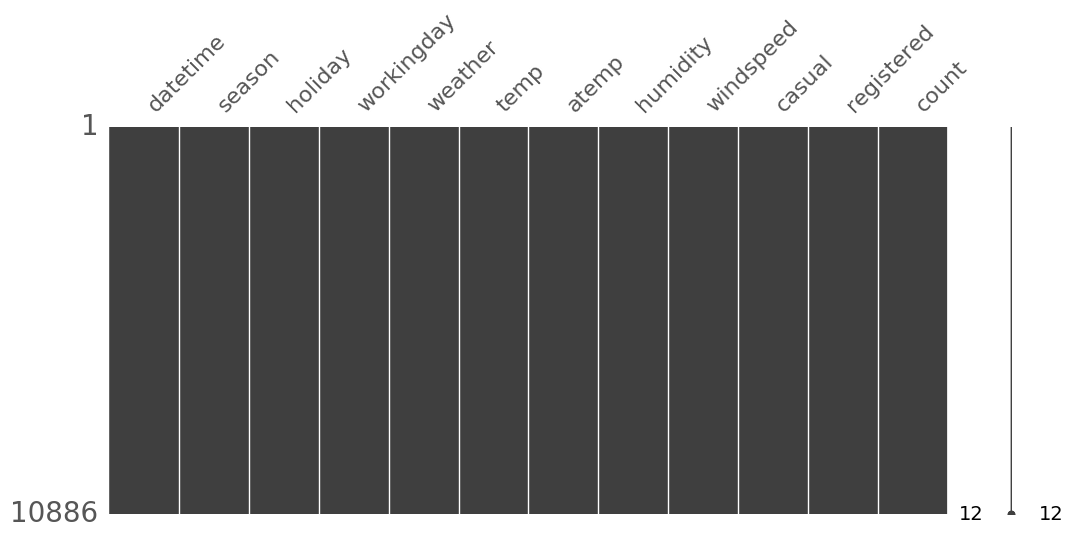

In [9]:
#없으면 pip install missingno
# null인 데이터가 있는지 시각화 해주는 툴.
import missingno as msno
msno.matrix(train,figsize=(12,5))

In [10]:
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.day
train["hour"] = train["datetime"].dt.hour
train["minute"] = train["datetime"].dt.minute
train["second"] = train["datetime"].dt.second
train.shape
#시각화해서 보기 편하도록 년 월 일 시분초로 나눔.

(10886, 18)

In [11]:
train.head()
# 다섯개만 찍는다.

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0


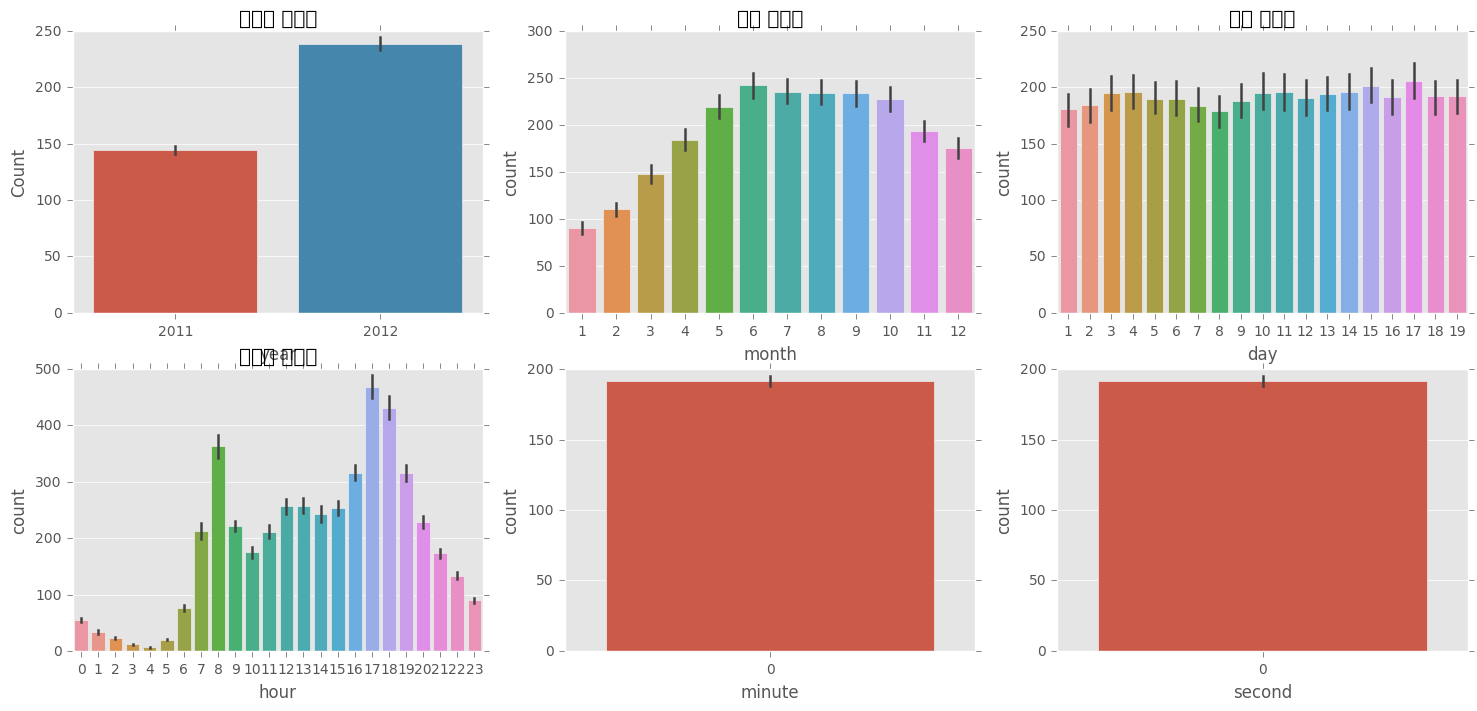

In [12]:
#matplotlib 에서 axis를 각각 alias 지정해주고, matplotlib 에서 행 2개 컬럼 3개
figure,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(nrows=2,ncols=3) # 행 2개 컬럼 3개
figure.set_size_inches(18,8)

sns.barplot(data=train, x="year",y="count",ax=ax1)
sns.barplot(data=train, x="month",y="count",ax=ax2)
sns.barplot(data=train, x="day", y="count",ax=ax3)
sns.barplot(data=train, x="hour",y="count",ax=ax4)
sns.barplot(data=train, x="minute",y="count",ax=ax5)
sns.barplot(data=train, x="second", y="count",ax=ax6)

# 한글코드는 matplotlib에서 한글코드 사용법을 봐야한다.

ax1.set(ylabel='Count',title = "연도별 대여량")
ax2.set(xlabel='month',title = '월별 대여량')
ax3.set(xlabel='day', title= '일별 대여량')
ax4.set(xlabel='hour', title = '시간별 대여량')

* 연도별 대여량은 2011년 보다 2012년이 더 많다.
* 월별 대여량은 6월에 가장많고 7~10월도 대여량이 많다. 그리고 1월에 가장 적다.
* 대여량은 1일부터 19일까지만 이고 나머지 날짜는 test.csv에 있따. 그래서 이 데이터는 피처로 사용하면 안된다.
* 대 대여량을 보면 출퇴근 시간에 대여량이 많은 것 같다. 하지만 주말과 나누어 볼 필요가 있을 것 같다.
* 초도 다 0이기 때문에 의미가 없다.

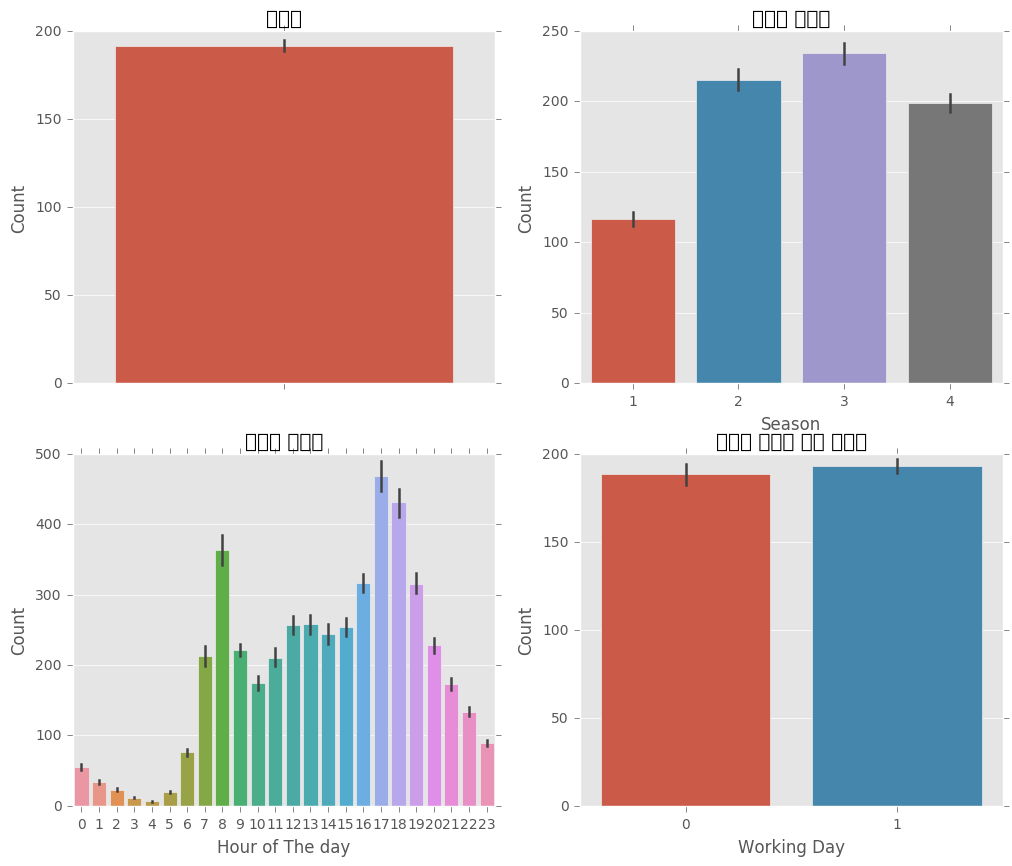

In [17]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12,10)
sns.barplot(data=train,y="count",orient="v", ax=axes[0][0])
sns.barplot(data=train,y="count",x="season",orient="v",ax=axes[0][1])
sns.barplot(data=train,y="count",x="hour",orient="v",ax=axes[1][0])
sns.barplot(data=train,y="count",x="workingday",orient="v", ax=axes[1][1])

axes[0][0].set(ylabel='Count',title='대여량')
axes[0][1].set(xlabel='Season',ylabel='Count',title='계절별 대여량')
axes[1][0].set(xlabel='Hour of The day', ylabel='Count',title='시간별 대여량')
axes[1][1].set(xlabel='Working Day',ylabel='Count',title='근무일 여부에 따른 대여량')

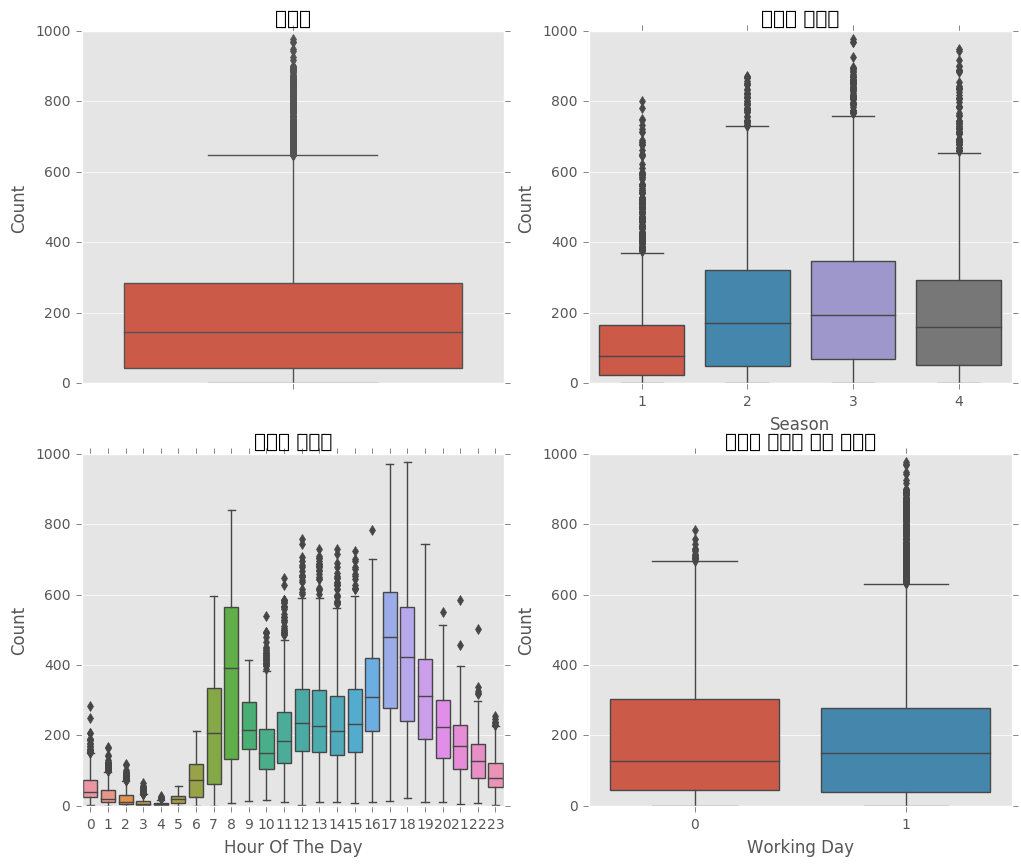

In [16]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
# 여기 예제에서는 boxplot이였는데...
# 내가 위에서 barplot으로 했구나.. VSC 로 찾아봄. 파일비교.
sns.boxplot(data=train,y="count",orient="v",ax=axes[0][0])
sns.boxplot(data=train,y="count",x="season",orient="v",ax=axes[0][1])
sns.boxplot(data=train,y="count",x="hour",orient="v",ax=axes[1][0])
sns.boxplot(data=train,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="대여량")
axes[0][1].set(xlabel='Season', ylabel='Count',title="계절별 대여량")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="시간별 대여량")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="근무일 여부에 따른 대여량")

In [18]:
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 19)

In [19]:
train["dayofweek"].value_counts()

5    1584
6    1579
3    1553
2    1551
0    1551
1    1539
4    1529
Name: dayofweek, dtype: int64

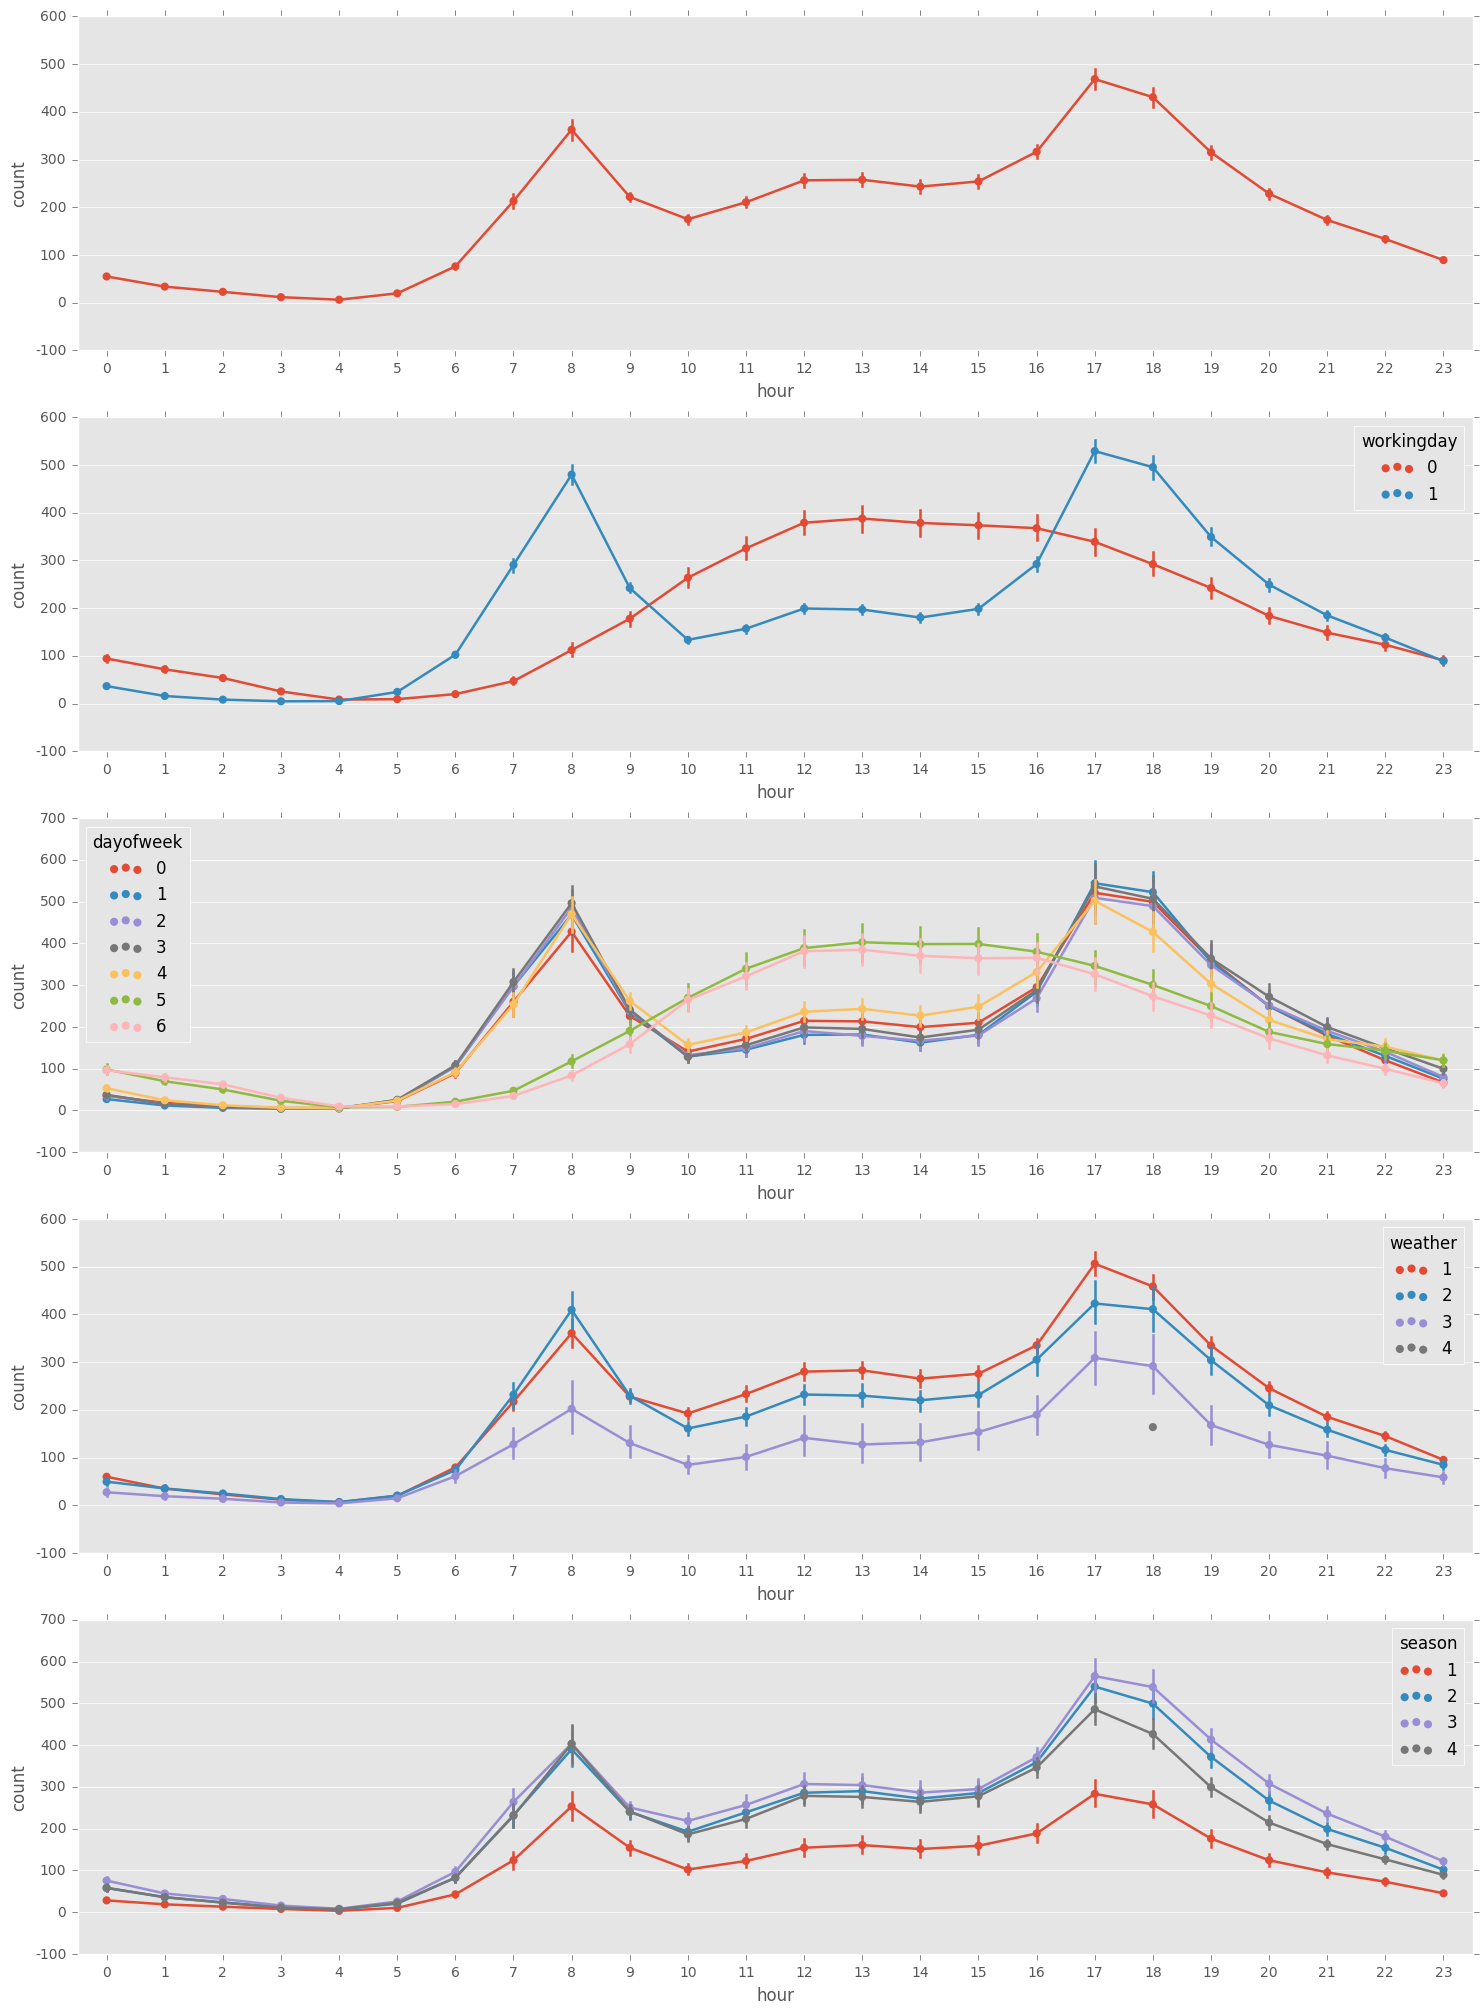

In [26]:
fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(nrows=5) # s 오타가 있었다.
fig.set_size_inches(18,25)       # s 오타가 있었다.


sns.pointplot(data=train, x="hour",y="count",ax=ax1)
sns.pointplot(data=train, x="hour",y="count",hue="workingday",ax=ax2)
sns.pointplot(data=train, x="hour",y="count",hue="dayofweek",ax=ax3)
sns.pointplot(data=train, x="hour",y="count",hue="weather",ax=ax4)
sns.pointplot(data=train, x="hour",y="count",hue="season",ax=ax5)


In [30]:
corrMatt = train[["temp","atemp","casual","registered","humidity","windspeed","count"]]
corrMatt = corrMatt.corr()
print(corrMatt)

mask = np.array(corrMatt)
print(type(mask))
print(mask)
print(np.tril_indices_from(mask))
mask[np.tril_indices_from(mask)] = False


                temp     atemp    casual  registered  humidity  windspeed  \
temp        1.000000  0.984948  0.467097    0.318571 -0.064949  -0.017852   
atemp       0.984948  1.000000  0.462067    0.314635 -0.043536  -0.057473   
casual      0.467097  0.462067  1.000000    0.497250 -0.348187   0.092276   
registered  0.318571  0.314635  0.497250    1.000000 -0.265458   0.091052   
humidity   -0.064949 -0.043536 -0.348187   -0.265458  1.000000  -0.318607   
windspeed  -0.017852 -0.057473  0.092276    0.091052 -0.318607   1.000000   
count       0.394454  0.389784  0.690414    0.970948 -0.317371   0.101369   

               count  
temp        0.394454  
atemp       0.389784  
casual      0.690414  
registered  0.970948  
humidity   -0.317371  
windspeed   0.101369  
count       1.000000  
<class 'numpy.ndarray'>
[[ 1.          0.98494811  0.46709706  0.31857128 -0.06494877 -0.01785201
   0.39445364]
 [ 0.98494811  1.          0.46206654  0.31463539 -0.04353571 -0.057473
   0.38978444]

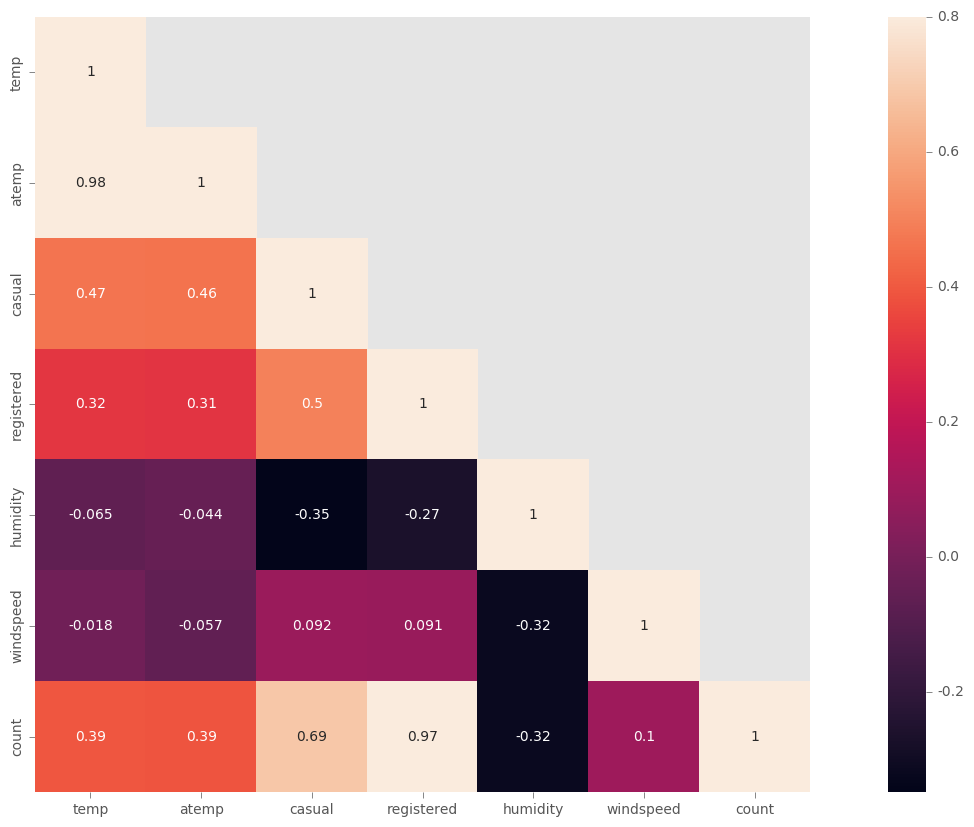

In [39]:
fig, ax = plt.subplots() # s를 빼먹었넹. 
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)
# 내가 vmask로 했나보다...

Count Row를 보면 registered만 0.97로 관련이 있고, 온도, 습도, 바람은 상관없나보다.


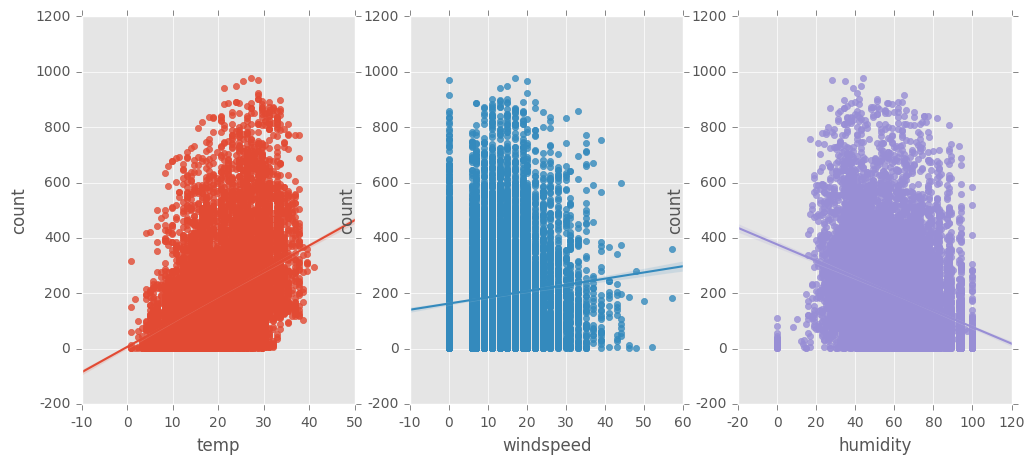

In [45]:
fig,(ax1,ax2,ax3)= plt.subplots(ncols=3)
fig.set_size_inches(12,5)
sns.regplot(x="temp",y="count", data=train,ax=ax1)
sns.regplot(x="windspeed",y="count",data=train, ax =ax2)
sns.regplot(x="humidity",y="count",data=train,ax=ax3)

풍속의 겨우 0에 숫자가 몰려있는 것으로 보인다. 아마 관측되지 않은 수치에 대해 0으로 기록한 것이 아닐까?
아니면 바람이 ㅇ벗었던 시간이 많은건가?

In [56]:
def concatenate_year_month(datetime):
    return "{0}--{1}".format(datetime.year,datetime.month)

train["year_month"] = train["datetime"].apply(concatenate_year_month)

#print(train.info)
#print(train.shape)

train[["datetime","year_month","day"]].head()


,datetime,year_month,day
0,2011-01-01 00:00:00,2011--1,1
1,2011-01-01 01:00:00,2011--1,1
2,2011-01-01 02:00:00,2011--1,1
3,2011-01-01 03:00:00,2011--1,1
4,2011-01-01 04:00:00,2011--1,1


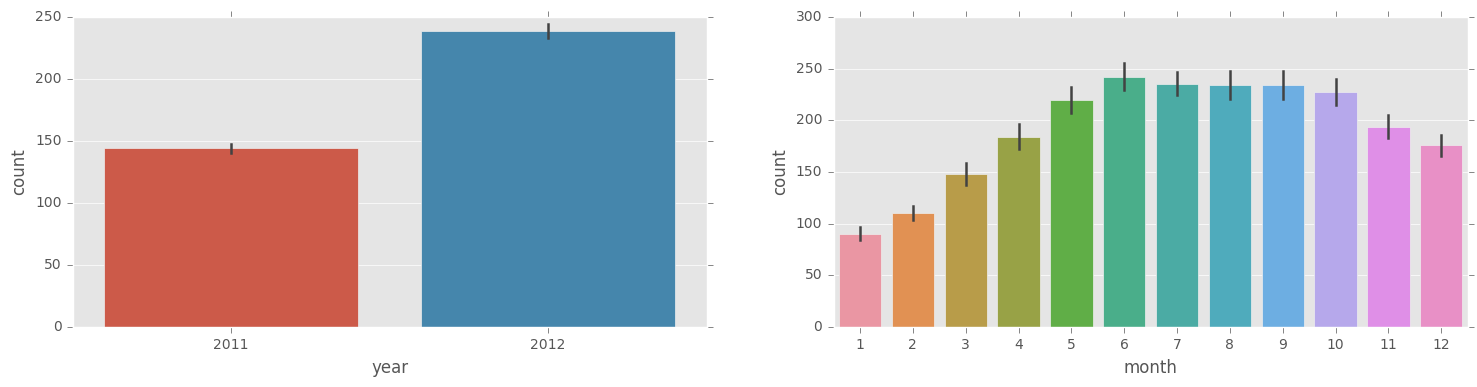

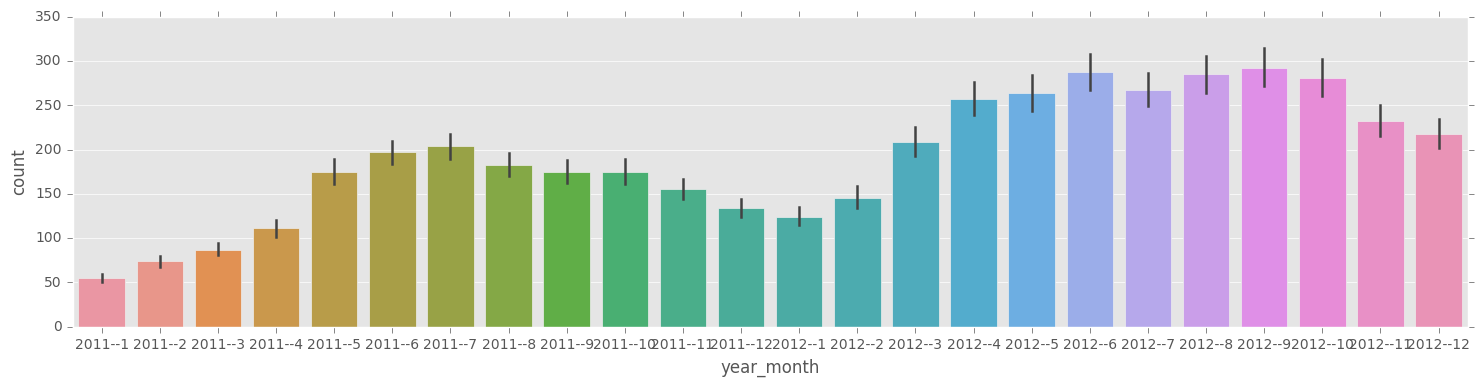

In [57]:
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(18,4)

sns.barplot(data=train,x="year",y="count",ax=ax1)
sns.barplot(data=train,x="month",y="count",ax=ax2)

fig,ax3 = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(18,4)
sns.barplot(data=train,x="year_month",y="count",ax=ax3)

2011년보다 2012년의 대여량이 더 많다.
겨울보다는 여름에 대여량이 많다.
2011년과 2012년의 월별 데이터를 이어보면 전체적으로 증가하는 추세이다.

In [59]:
trainWithoutOutliers = train[np.abs(train["count"] - train["count"].mean()) <= (3*train["count"].std())]

print(train.shape)
print(trainWithoutOutliers.shape)

(10886, 20)
(10739, 20)


C:\Users\Happy\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([ 0.69314718,  0.69314718,  0.69314718, ...,  6.5971457 ,
          6.59850903,  6.5998705 ])),
 (1.3486990121229776, 4.5624238680878078, 0.95811767809096116))

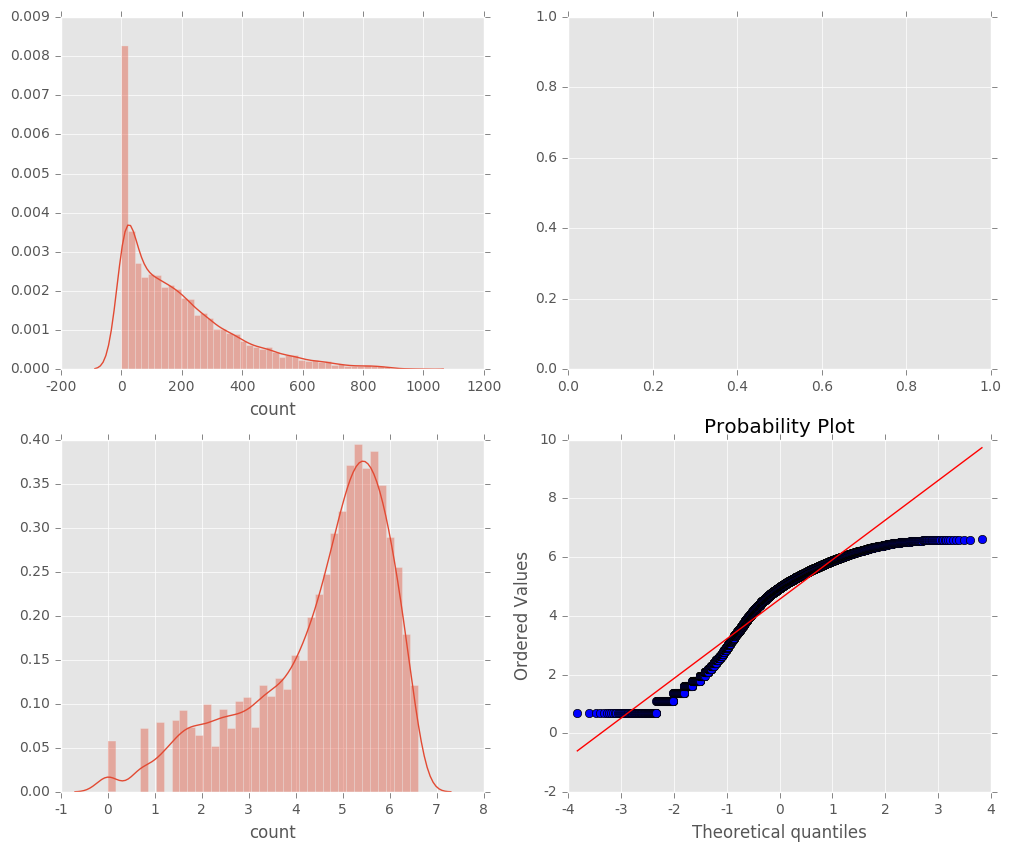

In [66]:
#count값의 데이터 분포도를 파악

figure,axes = plt.subplots(ncols=2,nrows=2)
figure.set_size_inches(12,10)

sns.distplot(train["count"], ax=axes[0][0])
stats.probplot(train["count"],dist='norm',fit=True, plot=axes[0][1])
sns.distplot(np.log(trainWithoutOutliers["count"]),ax = axes[1][0])
stats.probplot(np.log1p(trainWithoutOutliers["count"]),dist='norm',fit=True,plot=axes[1][1])

C:\Users\Happy\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([ 0.69314718,  0.69314718,  0.69314718, ...,  6.5971457 ,
          6.59850903,  6.5998705 ])),
 (1.3486990121229776, 4.5624238680878078, 0.95811767809096116))

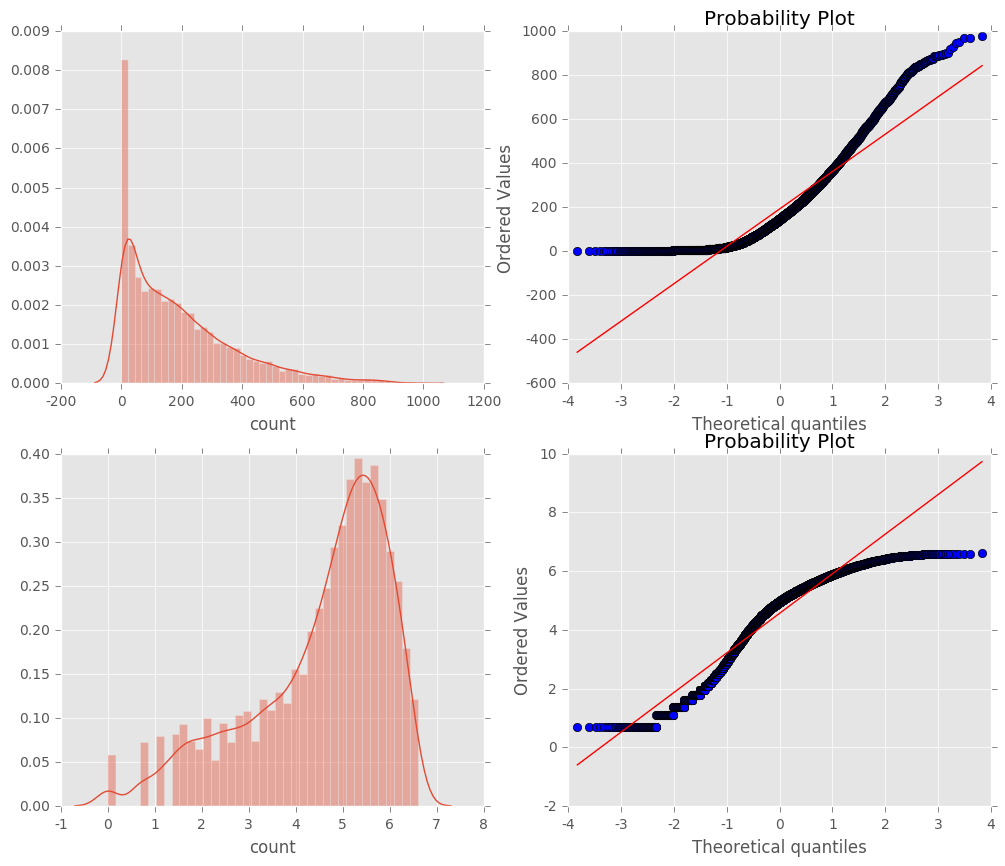

In [61]:
# count값의 데이터 분포도를 파악

figure, axes = plt.subplots(ncols=2, nrows=2)
figure.set_size_inches(12, 10)

sns.distplot(train["count"], ax=axes[0][0])
stats.probplot(train["count"], dist='norm', fit=True, plot=axes[0][1])
sns.distplot(np.log(trainWithoutOutliers["count"]), ax=axes[1][0])
stats.probplot(np.log1p(trainWithoutOutliers["count"]), dist='norm', fit=True, plot=axes[1][1])

count 변수가 오른쪽에 치우쳐져 있따. 대부분의 기계학습은 종속변수가 normal이어야 하기에 정규분포를 갖는 것이 바람직하다. 대안으로 outlier data를 제거하고 "count" 변수에 로그를 씌워 변경해 봐도 정규분포를 따르지는 않지만 이전 그래프보다는 좀 더 자세히 표현하고 있다.


https://github.com/corazzon/KaggleStruggle/blob/master/bike-sharing-demand/bike-sharing-demand-EDA.ipynb

참고 : EDA & Ensemble Model (Top 10 Percentile) | Kaggle

https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile

